In [122]:
import pandas as pd
from numpy import mean
from numpy import median
from numpy import array
import matplotlib.pyplot as plt
from matplotlib import pyplot
import random
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns


from warnings import catch_warnings
from warnings import filterwarnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from multiprocess import cpu_count
from joblib import Parallel

from joblib import delayed

In [123]:
## Funcion utilidad
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

# validación "walk-forward" para datos univariados
def validacion_al_frente(datos, n_prueba, metodo, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        if metodo == "promedio":
            yhat = prediccion_promedio(historia, cfg)
        elif metodo == "sarima":
            yhat = prediccion_sarima(historia, cfg)
        elif metodo == "exp":
            yhat = prediccion_alisamiento_exp(historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    return [error, predicciones]

def busqueda_malla(datos, lista_cfg, n_prueba, metodo = "sarima", paralelo = True):
    resultados = None
    if paralelo:
        # ejecutar las configuraciones en paralelo
        ejecutor = Parallel(n_jobs = cpu_count(), backend = 'multiprocessing') 
        tareas = (delayed(calificar_modelo)(datos, n_prueba, metodo, cfg) for cfg in lista_cfg) 
        resultados = ejecutor(tareas)
    else:
        resultados = [calificar_modelo(datos, n_prueba, metodo, cfg) for cfg in lista_cfg]
    # eliminar resultados vacíos
    resultados = [r for r in resultados if r[1] != None]
    print(len(resultados))
    return resultados



def calificar_modelo(datos, n_prueba, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir la confiuración a una llave
    llave = str(cfg)
    if debug:
        resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
    else:
        # una falla durante la validación del modelo sugiere una configuración inestable
        try:
        # nunca mostrar advertencias cuando se busca en malla...demasiado "ruido"
            with catch_warnings():
                filterwarnings("ignore")
                resultado, predicciones = validacion_al_frente(datos, n_prueba, metodo, cfg)
        except:
            error = None
    if resultado is not None:
        print(f' > Modelo{llave} {resultado:.3f}')
    return (llave, resultado, predicciones)

def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
    datos = series.values
    resultados = []
    # dividir los datos
    n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
    long_max = len(datos) - n_prueba
    print(f"Tamaño Entrenamiento {long_max}")
    print(f"Tamaño Prueba {n_prueba}")

    # configuraciones de los modelos
    if metodo == "sarima":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_sarima()
    elif metodo == "promedio":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_simple(long_max)
    elif metodo == "exp":
        print(f"Encontrando la mejor solución para {metodo}")
        lista_cfg = config_alisamiento_exp()
        datos = datos[:,0]
    # muestrear algunos
    if muestra:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        while len(resultados) < 5:
            lista_cfg_azar = random.sample(lista_cfg, k = 25)
            resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
    else:
        # búsqueda en malla
        resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
        
    
    # ordenan las configuraciones por error, ascendente
    resultados.sort(key = lambda tup: tup[1])


    print('terminado')
    # listar las mejores 3 configuraciones
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    # desplegar
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
    ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
    prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
    # Esconder las líneas de malla de la gráfica
    # ax.grid(False)

    # Esconder las marcas en los ejes
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
    plt.show()

#
#  Prediccion promedio (simple)
#

def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])


#
#  Prediccion SARIMA
#


def config_sarima():
    modelos = []
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    P_params = [0, 1]
    D_params = [0, 1]
    Q_params = [0, 1]
    m_params = [12]  # Assuming monthly data
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p, d, q), (P, D, Q, m), 'n']
                                modelos.append(cfg)
    return modelos

def prediccion_sarima(historia, config):
    orden, orden_estacional, _ = config
    modelo = SARIMAX(historia, order=orden, seasonal_order=orden_estacional,
                     enforce_stationarity=False, enforce_invertibility=False, maxiter=20)
    modelo_ajustado = modelo.fit(disp=False)
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]



#
#  Alizamiento exponencial - Holt-Winters
#

def config_alisamiento_exp(estacional=[12]):
    modelos = []
    t_params = ['add', 'mul']  # Include 'mul' for trend
    d_params = [True, False]
    s_params = ['add', 'mul']  # Include 'mul' for seasonality
    p_params = estacional
    b_params = [True, False]
    r_params = [True, False]
    
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = (t, d, s, p, b, r)  # Make sure cfg is a tuple
                            modelos.append(cfg)
    return modelos

# Adjusted prediction function
def prediccion_alisamiento_exp(historia, config):
    t, d, s, p, b, r = config
    if min(historia) <= 0:
        t = None if t == 'mul' else t
        s = None if s == 'mul' else s
    try:
        modelo = ExponentialSmoothing(historia, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p)
        modelo_ajustado = modelo.fit()
        yhat = modelo_ajustado.predict(start=len(historia), end=len(historia))
        return yhat[0]
    except Exception as e:
        print(f"Error for config {config}: {e}")
        return None

## Exploracion de datos

In [124]:
df = pd.read_csv("monthly-car-sales.csv", header=0, index_col=0)
df.head()

,Sales
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587


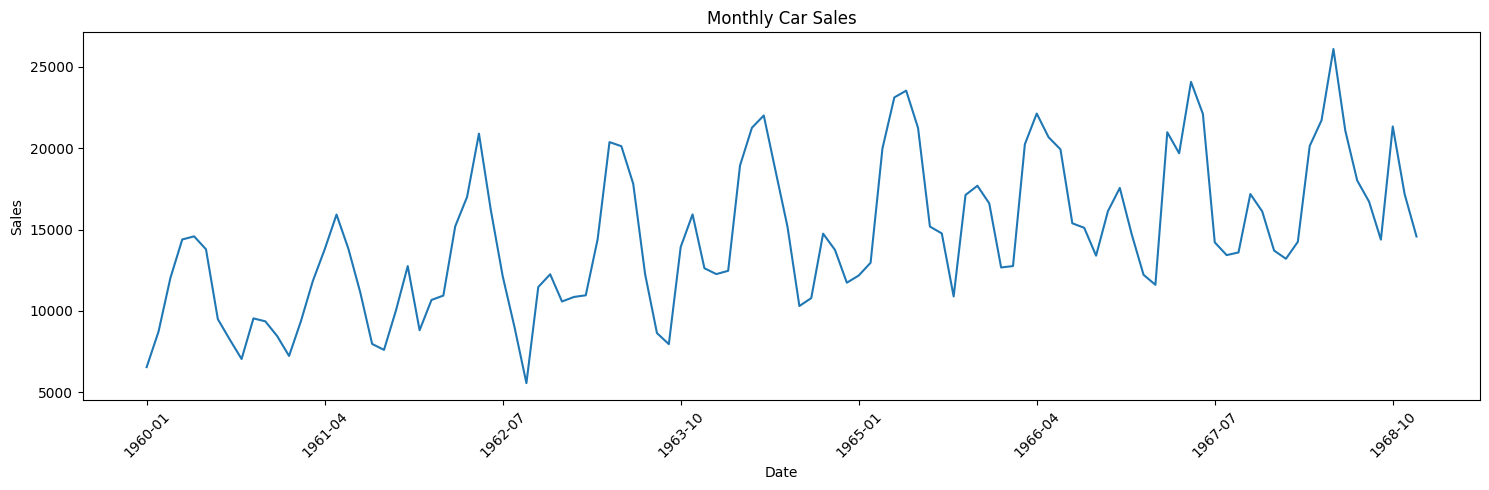

In [125]:
# Visualizing the time series
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.index, df['Sales'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_title('Monthly Car Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

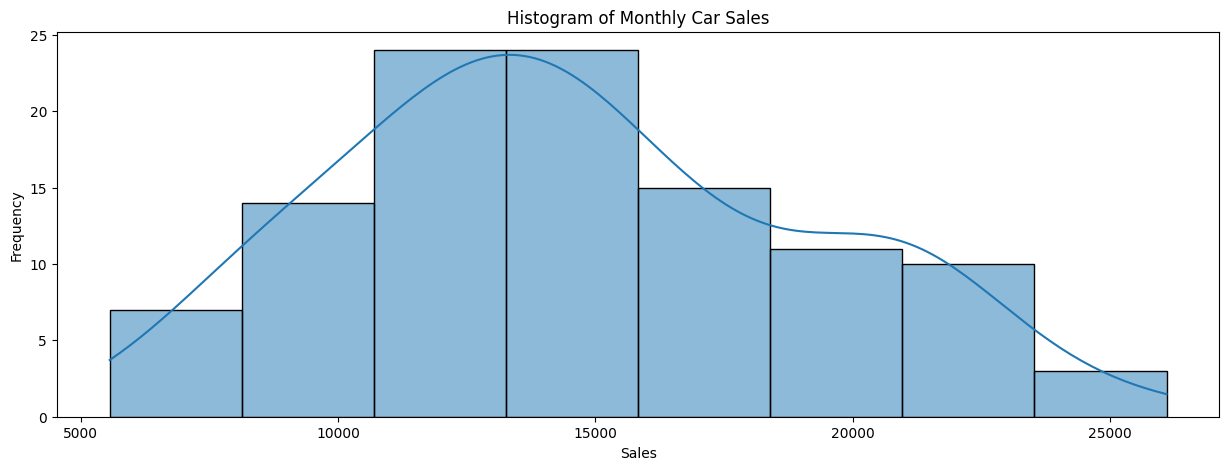

In [126]:
# Histogram visualization
plt.figure(figsize=(15, 5))
sns.histplot(df['Sales'], kde=True)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram of Monthly Car Sales')
plt.show()

## Promedios

MSE: 3783.9662392785694


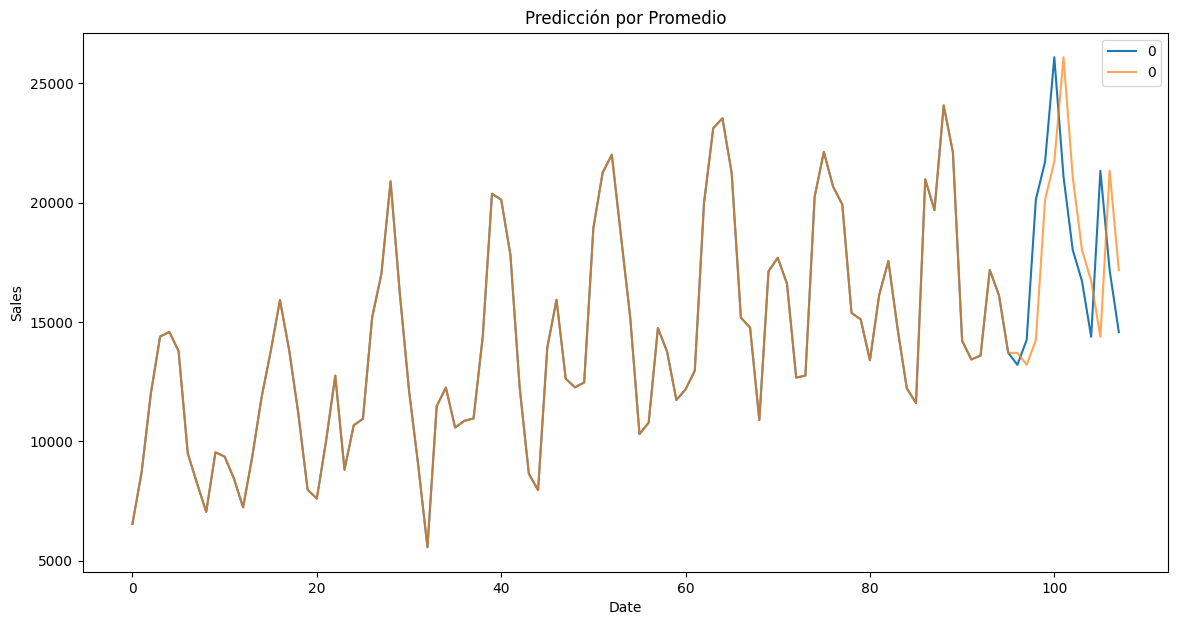

In [127]:
# Load the monthly-car-sales dataset
series = pd.read_csv('monthly-car-sales.csv', header=0, index_col=0)
datos = series.values
n_prueba = 12  # Assuming you want to predict 12 months (1 year) for testing
long_max = len(datos) - n_prueba
cfg = config_simple(long_max)[1]
entreno = datos[:-n_prueba]
prueba = datos[-n_prueba:]
historia = [x for x in entreno]    
predicciones = []
for i in range(len(prueba)):
    yhat = prediccion_promedio(historia, cfg)
    predicciones.append(yhat)
    historia.append(prueba[i])

error = sqrt(mean_squared_error(prueba, predicciones))
print("MSE:", error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)
ax = pd.DataFrame(datos).plot(label = "Original")  # Original data
plt.title('Predicción por Promedio')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc = 'upper left')

prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))
plt.show()

## SARIMA

In [128]:
# Load the monthly-car-sales dataset (assuming it's already loaded in 'series')
datos = series.values
n_prueba = 12  # Adjusted to predict 12 months (1 year) for testing
long_max = len(datos) - n_prueba
lista_cfg = config_sarima()
entreno = datos[:-n_prueba]
prueba = datos[-n_prueba:]
historia = [x for x in entreno]
predicciones = []

lista_cfg = random.sample(lista_cfg, k=10)
for cfg in lista_cfg:
    for i in range(len(prueba)):
        try:
            with catch_warnings():
                yhat = prediccion_sarima(historia, cfg)
                predicciones.append(yhat)
                historia.append(prueba[i])
        except:
            pass  # If there's an error, we just skip and move on

# Keep only the non-empty predictions
predicciones = [x for x in predicciones if x is not None]
error = sqrt(mean_squared_error(prueba, predicciones[:len(prueba)]))  # Adjusted to match the length of 'prueba'

c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 1891.67818103554


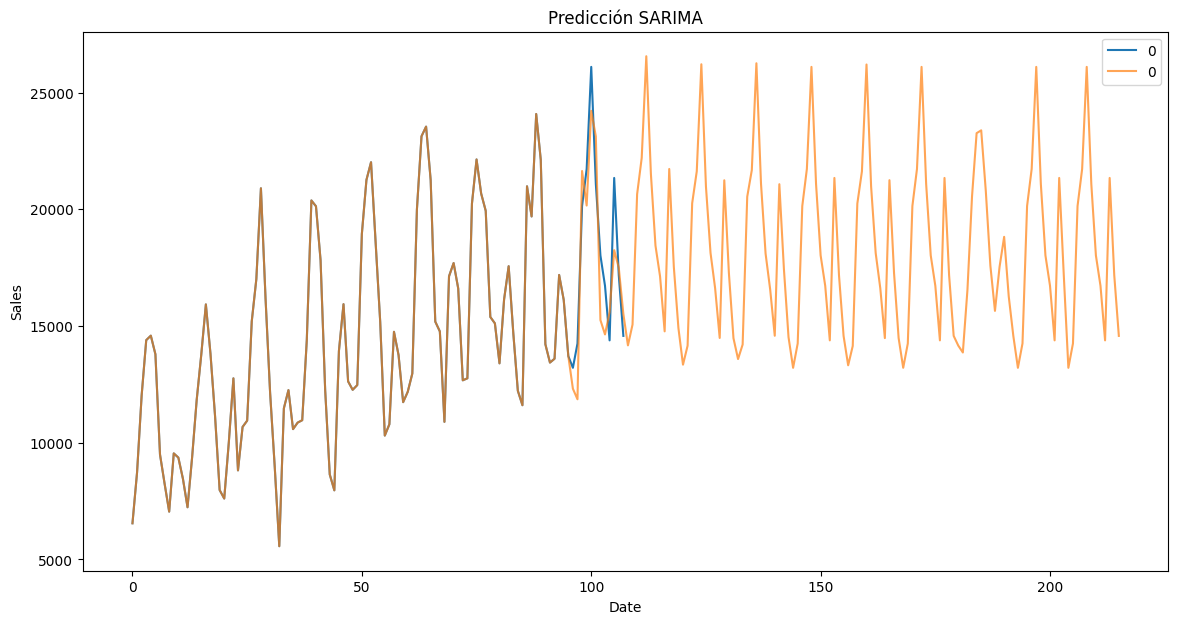

In [129]:
print("MSE:", error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones)
ax = pd.DataFrame(datos).plot(label="Original")  # Original data
plt.title('Predicción SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')

prediccion.plot(ax=ax, alpha=.7, figsize=(14, 7))
plt.show()

## Alisamiento exponencial

In [130]:
# Read the CSV data
series = pd.read_csv('monthly-car-sales.csv', header=0, index_col=0)
datos = series.values
n_prueba = 100
entreno = datos[:-n_prueba]
prueba = datos[-n_prueba:]
historia = [x for x in entreno]
predicciones = []

# Generate a sample of configurations
lista_cfg = config_alisamiento_exp()
lista_cfg_sample = random.sample(lista_cfg, k=3)

# Generate predictions
for cfg in lista_cfg_sample:
    for i in range(len(prueba)):
        try:
            yhat = prediccion_alisamiento_exp(historia, cfg)
            predicciones.append(yhat)
            historia.append(prueba[i])
        except Exception as e:
            print(f"Error during prediction with config {cfg}: {e}")

# Keep only the non-empty predictions
predicciones = [x for x in predicciones if x is not None]

if predicciones:
    # Calculate RMSE error using the first n_prueba predictions
    error = sqrt(mean_squared_error(prueba, predicciones[:n_prueba]))
    print("RMSE:", error)
else:
    print("No valid predictions found.")

Error for config ('add', False, 'add', 12, False, False): Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error for config ('add', False, 'add', 12, False, False): Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error for config ('add', False, 'add', 12, False, False): Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error for config ('add', False, 'add', 12, False, False): Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error for config ('add', False, 'add', 12, False, False): Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.
Error for config ('add', False, 'add', 12, False, False): Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data

c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warni

RMSE: 9713.697724073692


c:\Users\Jun\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MSE: 9713.697724073692


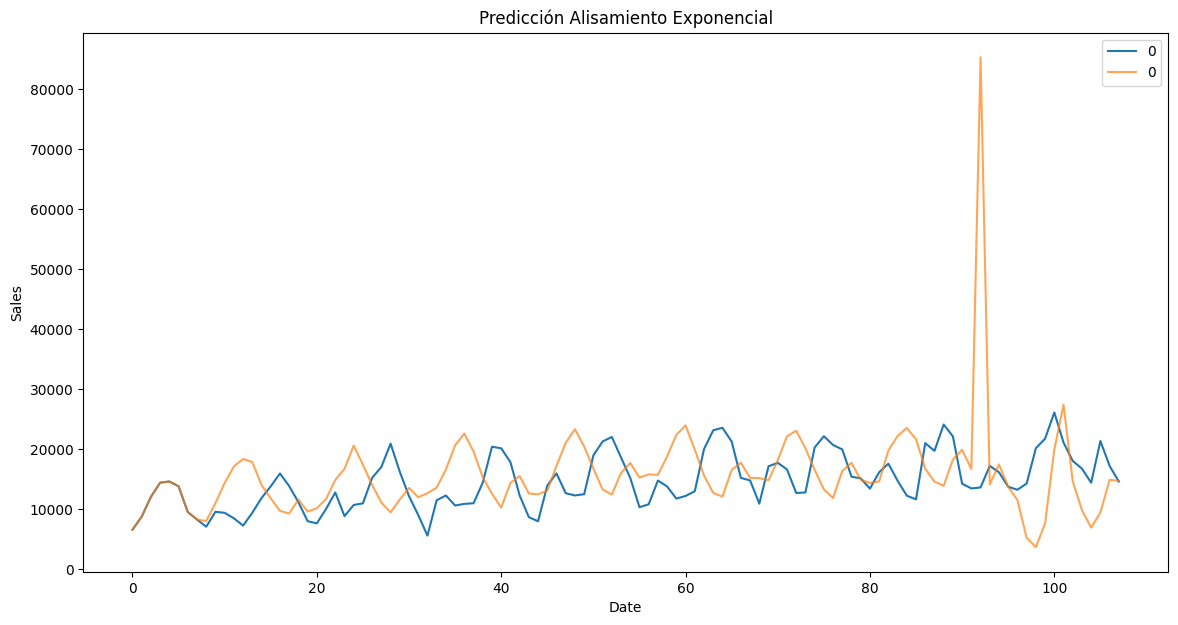

In [131]:
print("MSE:", error)

prediccion = pd.DataFrame(list(entreno.flatten()) + predicciones[:len(prueba)])  # Adjusted to match the length of 'prueba'
ax = pd.DataFrame(datos).plot(label="Original")  # Original data
plt.title('Predicción Alisamiento Exponencial')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')

prediccion.plot(ax=ax, alpha=.7, figsize=(14, 7))
plt.show()

## Prophet

In [132]:
from prophet import Prophet

prophet_series = pd.read_csv('monthly-car-sales.csv')
prophet_series['ds'] = pd.to_datetime(prophet_series['Month'])
prophet_series['y'] = prophet_series['Sales']
prophet_series = prophet_series[['ds', 'y']]

In [133]:
# Initialize and fit the Prophet model
modelo = Prophet(seasonality_mode='multiplicative')
modelo_ajustado = modelo.fit(prophet_series)

# Make future dataframe for predictions
futuro = modelo_ajustado.make_future_dataframe(periods=12, freq='M')

# Predict using the model
prediccion = modelo_ajustado.predict(futuro)

00:56:50 - cmdstanpy - INFO - Chain [1] start processing
00:56:50 - cmdstanpy - INFO - Chain [1] done processing


In [134]:
# Calculate RMSE error
error = sqrt(mean_squared_error(prophet_series['y'], prediccion['yhat'][:-12]))
print("RMSE:", error)

RMSE: 1298.6381260864255


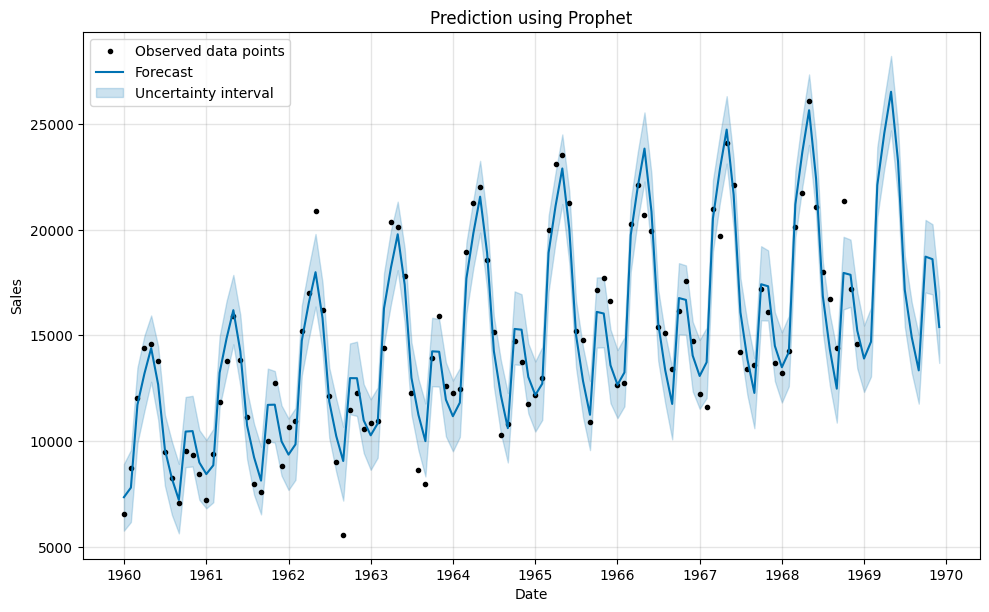

In [135]:
# Plot the predictions
modelo_ajustado.plot(prediccion)
plt.title('Prediction using Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()

## Redes Neuronales

In [136]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [137]:
# Split a univariate dataset into train/test sets
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

# Convert time series to supervised learning format
def series_a_supervisado(datos, n_entrada, n_salida=1):
    df = DataFrame(datos)
    cols = []
    
    for i in range(n_entrada, 0, -1):
        cols.append(df.shift(i))
    
    for i in range(0, n_salida):
        cols.append(df.shift(-i))
    
    agg = concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

# Measure RMSE
def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

# Fit a model
def ajustar_modelo(entreno, config):
    n_entrada, n_nodos, n_epocas, n_tandas = config
    datos = series_a_supervisado(entreno, n_entrada)
    entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
    
    modelo = tf.keras.Sequential()
    modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim=n_entrada))
    modelo.add(tf.keras.layers.Dense(1))
    modelo.compile(loss='mse', optimizer='adam')
    
    modelo.fit(entreno_x, entreno_y, epochs=n_epocas, batch_size=n_tandas, verbose=0)
    return modelo

# Make a prediction with a model
def prediccion_modelo(modelo, historia, config):
    n_entrada, _, _, _ = config
    x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
    yhat = modelo.predict(x_entrada, verbose=0)
    return yhat[0]

# Forecast with the model
def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    modelo = ajustar_modelo(entreno, cfg)
    historia = [x for x in entreno]
    
    for i in range(len(prueba)):
        yhat = prediccion_modelo(modelo, historia, cfg)
        predicciones.append(yhat)
        historia.append(prueba[i])
    
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

# Evaluate a model
def evaluacion_iter(datos, config, n_prueba, n_repeticiones=5):
    resultados = []
    predicciones = []
    
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    
    return [resultados, predicciones]

# Summarize results
def resumir_resultados(nombre, resultados):
    media_result, std_result = mean(resultados), std(resultados)
    print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
    pyplot.boxplot(resultados)
    pyplot.show()

# Search for the best solution
def buscar_mejor_solucion(series, nombre, metodo="red neuronal"):
    datos = series.values
    n_prueba = int(len(datos) * 0.2)
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    resumir_resultados('mlp', resultados)
    plt.savefig(f"resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original")
    prediccion.plot(ax=ax, alpha=.7, figsize=(14, 7))
    plt.savefig(f"pred_{nombre}_{metodo}.png")
    plt.show()

 > 1971.500
 > 2029.317
 > 2080.762
 > 1907.583
 > 2002.234
mlp: 1998.280 RMSE (+/- 57.837)


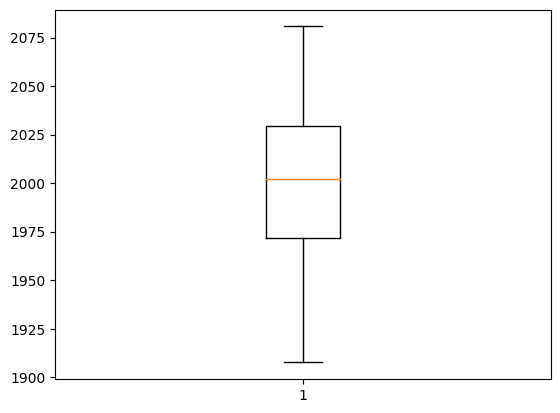

<Figure size 640x480 with 0 Axes>

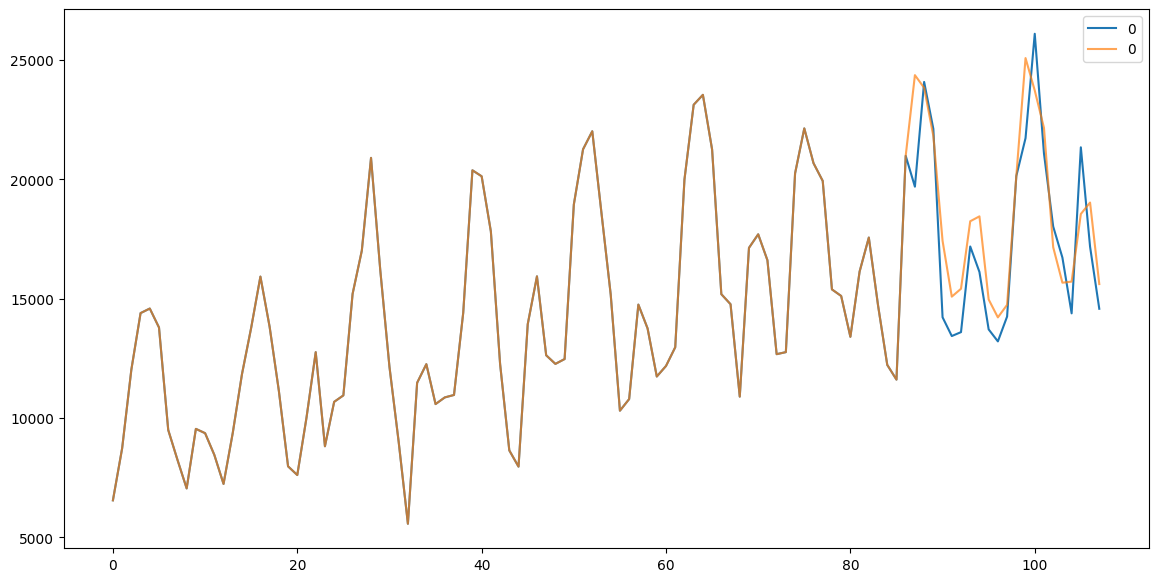

In [138]:
series_car_sales = pd.read_csv('monthly-car-sales.csv', header=0, index_col=0)
buscar_mejor_solucion(series_car_sales, "car_sales")

In [139]:
print(long_max)

96
